In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Reading the data

We will use a Visium spatial transcriptomics dataset of the human lymphnode, which is publicly available from the 10x genomics website: link.

The function datasets.visium_sge() downloads the dataset from 10x Genomics and returns an AnnData object that contains counts, images and spatial coordinates. We will calculate standards QC metrics with pp.calculate_qc_metrics and percentage of mitochondrial read counts per sample.

When using your own Visium data, use sc.read_visium() function to import it.



In [2]:
adata = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata.var_names_make_unique()
# Doing QC based on presence of mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## What is "adata"?

<img src="images/anndata.svg">

The "adata" that we loaded is a form of annotated data or "anndata" data structure. In the case of scanpy, the package we are using, the main "green" matrix or the .X matrix is all of our observed barcodes (which encode a specific spot on the slide) as rows and all of our gene variables as columns. The matrix values themselves are the gene counts for that specific observed spot for a specific gene.

There are also two additional matrices that let you tag on as many annotations you need for each unique observation or variable. So for our scenario, this would include the (x,y) coordinates of our spots!

# Taking a look at our specific adata file
adata

# QC and preprocessing

Let's take a look at our distribution of gene counts for each spot

C:\Users\noa001\.conda\envs\class_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\noa001\.conda\envs\class_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\noa001\.conda\envs\class_env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar 

<AxesSubplot:xlabel='n_genes_by_counts'>

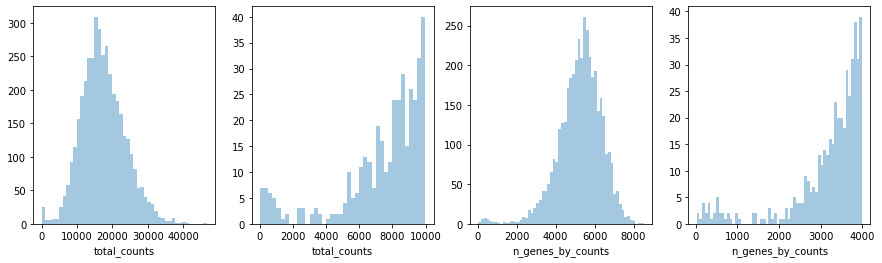

In [3]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

### Fliter out spots (that we're treating as single "cells") with too few or too many gene counts

In [4]:
sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=35000)

### Filter out spots that have too many mitochondrial genes

In [5]:
adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {adata.n_obs}")

#cells after MT filter: 3962


### Remove genes that are present in very few spots

In [6]:
sc.pp.filter_genes(adata, min_cells=10)

Trying to set attribute `.var` of view, copying.


#### Since we've removed quite a few spots and genes, we need to normalize our data again to improve our results later on such as for differential expression

In [7]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

### Now we only care about genes that are actually highly variable in expression between spots. Let's tease these out!

In [8]:
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

# Manifold embedding and clustering based on transcriptional similarity

Like with single-cell sequencing, it is interesting to cluster "spots" by gene expression similarities and differences. What we hope to see is that the clusters we find solely by looking at gene expression will also cluster spatially!!

In [9]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")

### We plot some covariates to check if there is any particular structure in the UMAP associated with total counts and detected genes

... storing 'feature_types' as categorical
... storing 'genome' as categorical


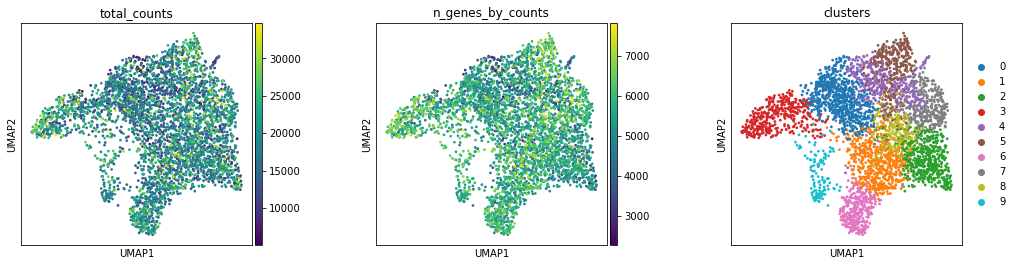

In [10]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

# Visualization in spatial coordinates

Let us now take a look at how total_counts and n_genes_by_counts behave in spatial coordinates. We will overlay the circular spots on top of the Hematoxylin and eosin stain (H&E) image provided, using the function sc.pl.spatial.

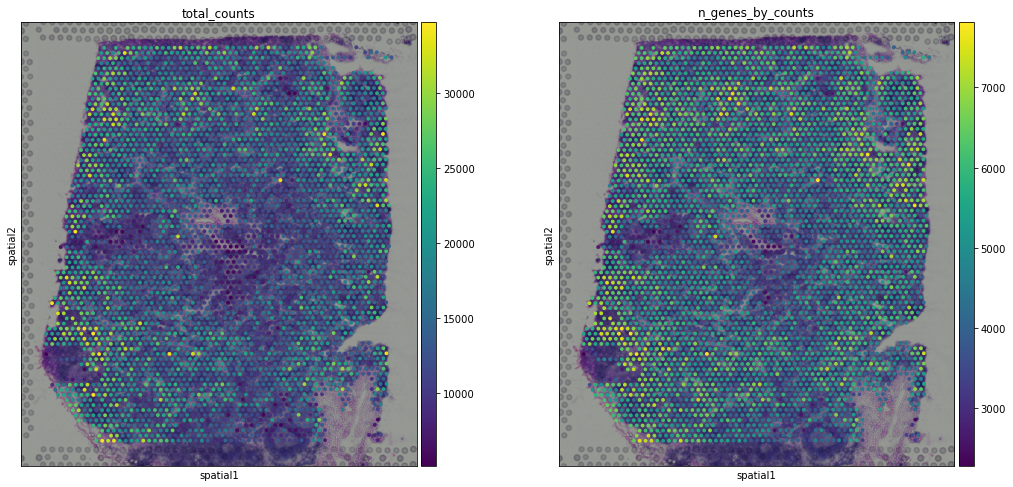

In [11]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

The function *sc.pl.spatial* accepts 4 additional parameters:

img_key: key where the img is stored in the adata.uns element

crop_coord: coordinates to use for cropping (left, right, top, bottom)

alpha_img: alpha value for the transcparency of the image

bw: flag to convert the image into gray scale

Furthermore, in sc.pl.spatial, the size parameter changes its behaviour: it becomes a scaling factor for the spot sizes.

Before, we performed clustering in gene expression space, and visualized the results with UMAP. By visualizing clustered samples in spatial dimensions, we can gain insights into tissue organization and, potentially, into inter-cellular communication.

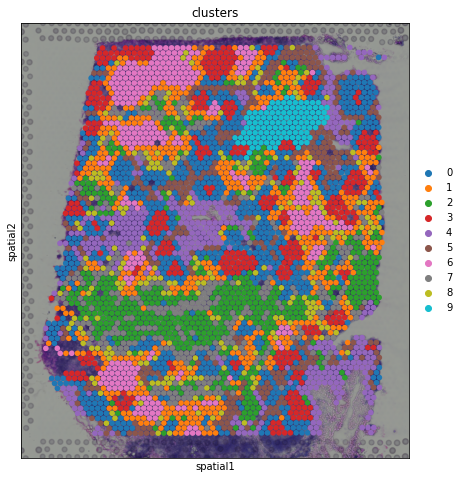

In [12]:
# View our UMAP clusters from before in the tissue itself
sc.pl.spatial(adata, img_key="hires", color="clusters", size=1.5)

Spots belonging to the same cluster in gene expression space often co-occur in spatial dimensions. For instance, spots belonging to cluster 5 are often surrounded by spots belonging to cluster 0.

We can zoom in specific regions of interests to gain qualitative insights. Furthermore, by changing the alpha values of the spots, we can visualize better the underlying tissue morphology from the H&E image.

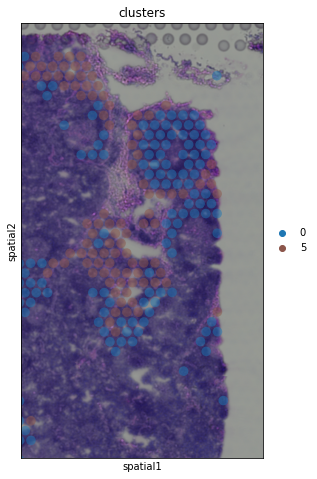

In [13]:
sc.pl.spatial(adata, img_key="hires", color="clusters", groups=["0", "5"], crop_coord=[1200, 1700, 1900, 1000], alpha=0.5, size=1.3)

# Cluster marker genes

Let us further inspect cluster 5, which occurs in small groups of spots across the image.

Compute marker genes and plot a heatmap with expression levels of its top 10 marker genes across clusters.

categories: 0, 1, 2, etc.
var_group_labels: 5


C:\Users\noa001\.conda\envs\class_env\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


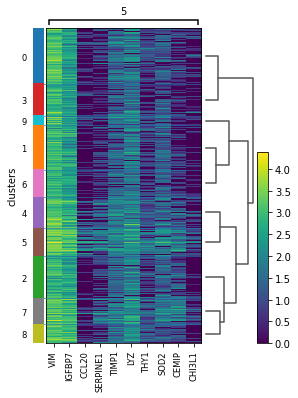

In [14]:
sc.tl.rank_genes_groups(adata, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(adata, groups="5", n_genes=10, groupby="clusters")

### Let's see if CR2 does actually recapitulate the spatial structure

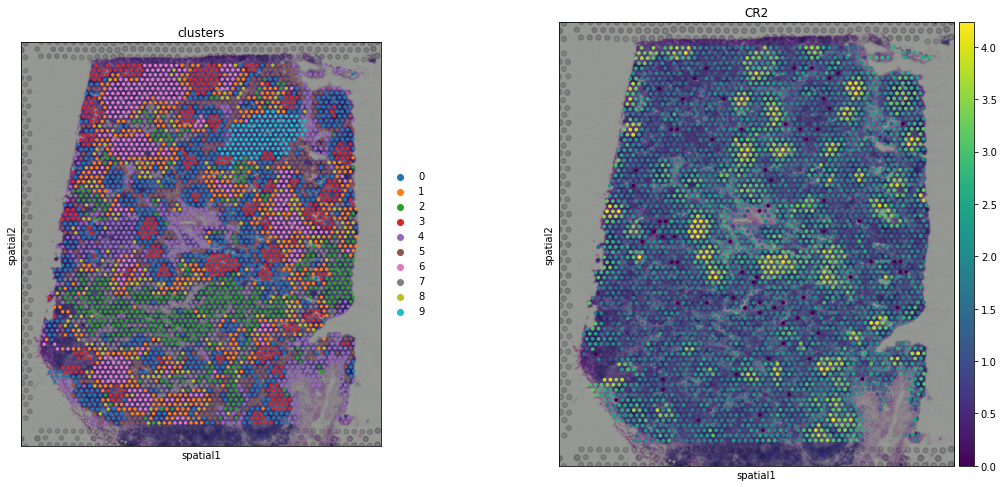

In [15]:
sc.pl.spatial(adata, img_key="hires", color=["clusters", "CR2"])

Pretty neat!!

# Try for yourself!
## Try plotting other genes in the dendogram clustering (or other genes present in the anndata file) and see what the distribution is like spatially!

In [16]:
# Your code here

In [17]:
# Maybe do a second one too

# Spatially variable genes (Optional...do at home if you're curious)

Spatial transcriptomics allows researchers to investigate how gene expression trends varies in space, thus identifying spatial patterns of gene expression. For this purpose, we use SpatialDE Svensson18, a Gaussian process-based statistical framework that aims to identify spatially variable genes:

In [19]:
import SpatialDE

In [ ]:
# this can take close to an hour
counts = pd.DataFrame(adata.X.todense(), columns=adata.var_names, index=adata.obs_names)
coord = pd.DataFrame(adata.obsm['spatial'], columns=['x_coord', 'y_coord'], index=adata.obs_names)
results = SpatialDE.run(coord, counts)

C:\Users\noa001\.conda\envs\class_env\lib\site-packages\SpatialDE\base.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
C:\Users\noa001\.conda\envs\class_env\lib\site-packages\SpatialDE\base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/18467 [00:00<?, ?it/s]

We concatenate the results with the DataFrame of annotations of variables:

In [ ]:
results.index = results["g"]
adata.var = pd.concat([adata.var, results.loc[adata.var.index.values, :]], axis=1)

Then we can inspect significant genes that varies in space and visualize them with sc.pl.spatial function.

In [ ]:
results.sort_values("qval").head(10)

In [ ]:
sc.pl.spatial(adata, img_key="hires", color=["COL1A2", "SYPL1"], alpha=0.7)